In [1]:
import pandas as pd 
import numpy as np
import datetime
import matplotlib 
import matplotlib.pyplot as plt

from utils import create_date_features, compute_cost_distributions, compute_uplift, strategy_mapping, cost_commitment_ratio, fund_size_standardizer, fund_vintage_normalizer, compute_momentum_factors
from tests import check_fund_proportions, compute_accuracy, accuracy_pipeline, check_dist_cost_calcs, check_uplift_calc_1, check_uplift_calc_2

import sklearn 
import xgboost 
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

## Training Switch

In [2]:
# Set the training variable to False if the model training should be ignored, True if we want to retrain the model
training = False

## Load in the data 

In [3]:
file_path = 'anon-ds-test-data.csv'

data = pd.read_csv(file_path)

In [4]:
# Convert the Date Quarter to a datimetime object 
data['Date_Quarter'] = pd.to_datetime(data['Date_Quarter'], dayfirst=True)

# Visualise the form of the dataframe 
data.head()

,Date_Quarter,Fund_ID,Quarter_ID,Quarter_TzeroID,Strategy,Region,Fund_Vintage,Dist_USD_cumulative,Cost_USD_cumulative,FMV_USD_cumulative,Commitment_USD_cumulative
0,1994-03-31,82844,377,1,MediumBO,US,1994,267750.0,14142450.0,13874700.0,350000000.0
1,1994-03-31,89037,377,1,MediumBO,US,1994,161640.0,15321960.0,15160320.0,360000000.0
2,1994-03-31,105324,377,1,VC,US,1994,19764.0,1028457.0,1008693.0,27000000.0
3,1994-03-31,119234,377,1,VC,US,1994,149084.0,2568100.0,2419016.0,61000000.0
4,1994-03-31,131151,377,1,VC,US,1994,16170.0,413760.0,397590.0,15000000.0


In [5]:
# Quick check of the number of unqiue data points / summary statistics 
data.describe()

,Date_Quarter,Fund_ID,Quarter_ID,Quarter_TzeroID,Fund_Vintage,Dist_USD_cumulative,Cost_USD_cumulative,FMV_USD_cumulative,Commitment_USD_cumulative
count,4712,4712.000000,4712.000000,4712.000000,4712.000000,4.712000e+03,4.712000e+03,4.712000e+03,4.712000e+03
mean,2008-01-21 12:58:22.207130624,108006.884338,432.240450,31.379669,2000.215195,1.339840e+09,1.364548e+09,6.393326e+08,1.675361e+09
min,1994-03-31 00:00:00,79649.000000,377.000000,1.000000,1994.000000,0.000000e+00,8.032500e+04,-2.980000e-08,1.200000e+07
25%,2002-12-31 00:00:00,97821.000000,412.000000,15.000000,1998.000000,2.151494e+07,1.779929e+08,4.007730e+07,4.230000e+08
50%,2007-12-31 00:00:00,109213.000000,432.000000,30.000000,2000.000000,2.316186e+08,5.220120e+08,1.604113e+08,6.460000e+08
75%,2012-12-31 00:00:00,119234.000000,452.000000,46.000000,2002.000000,1.196697e+09,1.498080e+09,5.550663e+08,2.170000e+09
max,2021-06-30 00:00:00,133399.000000,486.000000,88.000000,2013.000000,1.890069e+10,1.365956e+10,1.226517e+10,1.537200e+10
std,NaN,15123.163379,24.793353,19.548544,3.495935,2.724732e+09,2.107920e+09,1.309580e+09,2.387434e+09


In [6]:
# What is the split between the different fund types?
VC_len = len(data[data['Strategy']=='VC']['Fund_ID'].unique())
MediumBO_len = len(data[data['Strategy']=='MediumBO']['Fund_ID'].unique())
MegaBO_len = len(data[data['Strategy']=='MegaBO']['Fund_ID'].unique())
Total_len = len(data['Fund_ID'].unique())

print(f'The number of data points for VC funds is {VC_len}, {(VC_len/Total_len):.0%} of the total\n')

print(f'The number of data points for MediumBO funds is {MediumBO_len}, {(MediumBO_len/Total_len):.0%} of the total\n')

print(f'The number of data points for MegaBO funds is {MegaBO_len}, {(MegaBO_len/Total_len):.0%} of the total\n')

The number of data points for VC funds is 45, 39% of the total

The number of data points for MediumBO funds is 42, 36% of the total

The number of data points for MegaBO funds is 29, 25% of the total



## Feature Engineering

### Create the PE specific features of TVPI, DPI, RVPI

#### TVPI is the 'Total Value to Paid In' and accounts for the distributions to date and the current fair market value. It can be broken down to its two components of DPI and RVPI such that 

\begin{align}
TVPI = DPI + RVPI
\end{align}

#### It can be computed as 

\begin{align}
\frac{Cumulative \ Distributions + Residual \ FMV}{Cost}
\end{align}

#### In the dataset our numerator would consist of the 'Dist_USD_cumulative' and 'FMV_USD_cumulative' and the denominator would be the 'Cost_USD_cumulative'

In [7]:
# TVPI
data['TVPI'] = (data['Dist_USD_cumulative']+data['FMV_USD_cumulative'])/data['Cost_USD_cumulative']

#### The DPI is the ratio of the distributions to the paid in capital 

\begin{align}
\frac{Cumulative \ Distributions}{Cost}
\end{align}

#### In the dataset our numerator would consist of the 'Dist_USD_cumulative' and the denominator would be the 'Cost_USD_cumulative'

In [8]:
data['DPI'] = (data['Dist_USD_cumulative'])/data['Cost_USD_cumulative']

#### The RVPI is the ratio of the residual FMV to the paid in capital 

\begin{align}
\frac{Residual \ FMV}{Cost}
\end{align}

#### In the dataset our numerator would consist of the 'FMV_USD_cumulative' and the denominator would be the 'Cost_USD_cumulative'

In [9]:
data['RVPI'] = data['FMV_USD_cumulative']/data['Cost_USD_cumulative']

### The different fund types have different characteristics (strategy / risk profile / cost of capital etc) and so are not uniform features and potentially informative. We convert them to simple encodings below

In [10]:
# Create the date features 
data = create_date_features(data)

# Run the 'compute_cost_distributions' function to get the distributions and costs by quarter 
df_dist_costs = data.groupby('Fund_ID')[['Dist_USD_cumulative', 'Cost_USD_cumulative']].apply(compute_cost_distributions).reset_index(level=0, drop=True)

# Concatenate the new dataframe with the original DataFrame which we will use with 
data_1 = pd.concat([data, df_dist_costs], axis=1)

# Run the 'compute_momentum_factors' function to get momentum factors for distributions, costs and FMV
data_1 = data_1.groupby(['Fund_ID']).apply(compute_momentum_factors).reset_index(level=0, drop=True)
# Replace the inf values in the momentum factors so not to break the model
data_1 = data_1.replace([np.inf, -np.inf], [2, -2])

# Checking if any NaN values remain 
total_nan_vals = data_1.isna().any().sum()
print(total_nan_vals)

0


In [11]:
# Mapping for the values of the fund type to an encoding 
data_1 = strategy_mapping(data_1)

# Add a feature showing the cost as a % of total fund commitment
data_1 = cost_commitment_ratio(data_1)

# Add a feature which standardizes the fund commitment size within its strategy. 
# This should provide some signal in relation to the performance of fund size within its strategy 
data_1 = data_1.groupby(['Strategy_mapping']).apply(fund_size_standardizer).reset_index(level=0, drop=True)

MediumBO         Axes(0.1,0.15;0.235294x0.75)
MegaBO      Axes(0.382353,0.15;0.235294x0.75)
VC          Axes(0.664706,0.15;0.235294x0.75)
dtype: object

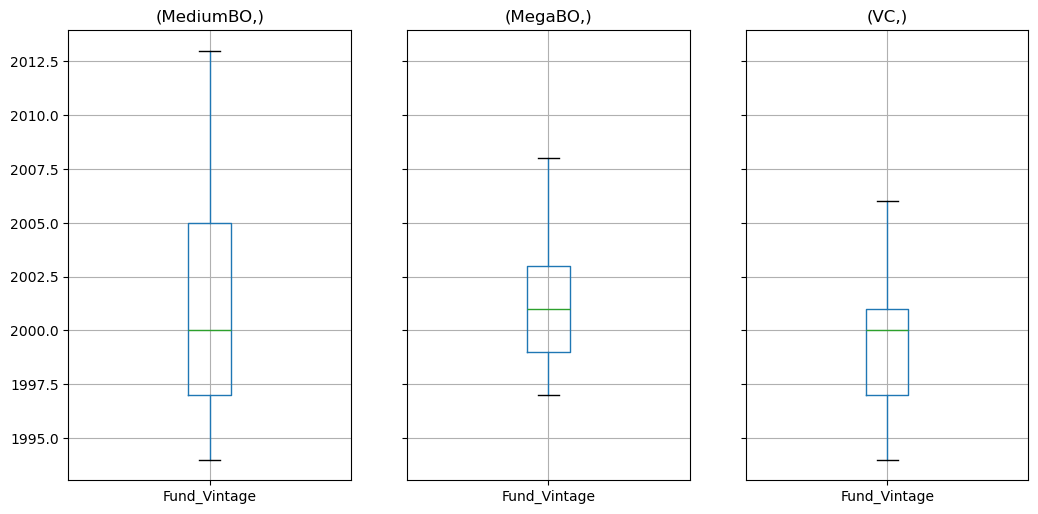

In [12]:
# Visualise a boxplot of the fund vintages grouped by fund strategy. 
# We want to create an additional feature which is the min-max scaled Fund_Vintage by Strategy 
# We do this because of the different distribution of fund vintages across the strategies 
# Opted for min-max scaling here rather than z-scoring as it feels less informative 
data_1.groupby(['Strategy']).boxplot(column=['Fund_Vintage'], figsize=(12,6), layout=(1,3))

In [13]:
# Create the Fund_Vintage_MinMax feature which is the Fund_Vintage having been MinMax scaled within Strategy
data_1 = data_1.groupby('Strategy_mapping').apply(fund_vintage_normalizer).reset_index(level=0, drop=True)

### Creating polynomial interaction features

In [14]:
# Create some polynomial features from the data 
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

# Drop these features for the polynomial features as they are not relevant 
features_to_exclude = ['Region', 'Strategy', 'Date_Quarter', 'Fund_ID']    

poly_features = poly.fit_transform(data_1.drop(columns=features_to_exclude))
poly_feature_names = poly.get_feature_names_out(input_features = data_1.columns.drop(features_to_exclude))

# Create a new dataframe with the polynomial features 
poly_df = pd.DataFrame(poly_features, columns = poly_feature_names, index=data_1.index)

# Concatenate with the original dataframe
data_1 = pd.concat([data_1, poly_df], axis=1)

data_1 = data_1.loc[:, ~data_1.columns.duplicated()]

data_1.sort_index(inplace=True)

In [15]:
data_1

,Date_Quarter,Fund_ID,Quarter_ID,Quarter_TzeroID,Strategy,Region,Fund_Vintage,Dist_USD_cumulative,Cost_USD_cumulative,FMV_USD_cumulative,...,Strategy_mapping Cost_commitment_ratio,Strategy_mapping Cost_commitment_ratio_cumulative,Strategy_mapping Fund_commitment_z_score_Expanding,Strategy_mapping Fund_Vintage_MinMax_Expanding,Cost_commitment_ratio Cost_commitment_ratio_cumulative,Cost_commitment_ratio Fund_commitment_z_score_Expanding,Cost_commitment_ratio Fund_Vintage_MinMax_Expanding,Cost_commitment_ratio_cumulative Fund_commitment_z_score_Expanding,Cost_commitment_ratio_cumulative Fund_Vintage_MinMax_Expanding,Fund_commitment_z_score_Expanding Fund_Vintage_MinMax_Expanding
0,1994-03-31,82844,377,1,MediumBO,US,1994,2.677500e+05,1.414245e+07,13874700.0,...,0.080814,0.080814,0.000000,0.0,0.001633,0.000000,0.0000,0.000000,0.0000,0.000000
1,1994-03-31,89037,377,1,MediumBO,US,1994,1.616400e+05,1.532196e+07,15160320.0,...,0.085122,0.085122,-1.910559,0.0,0.001811,-0.040658,0.0000,-0.040658,0.0000,-0.000000
2,1994-03-31,105324,377,1,VC,US,1994,1.976400e+04,1.028457e+06,1008693.0,...,0.038091,0.038091,-1.083483,0.0,0.001451,-0.041271,0.0000,-0.041271,0.0000,-0.000000
3,1994-03-31,119234,377,1,VC,US,1994,1.490840e+05,2.568100e+06,2419016.0,...,0.042100,0.042100,-1.103258,0.0,0.001772,-0.046447,0.0000,-0.046447,0.0000,-0.000000
4,1994-03-31,131151,377,1,VC,US,1994,1.617000e+04,4.137600e+05,397590.0,...,0.027584,0.027584,-1.152202,0.0,0.000761,-0.031782,0.0000,-0.031782,0.0000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4707,2021-03-31,112457,485,85,MegaBO,US,2000,7.598908e+09,4.046494e+09,127460916.0,...,0.000000,3.007800,-0.097462,1.0,0.000000,-0.000000,0.0000,-0.032572,0.3342,-0.010829
4708,2021-03-31,114079,485,85,VC,US,2000,1.502962e+09,1.625000e+09,29575000.0,...,0.000000,1.000000,1.904862,0.5,0.000000,0.000000,0.0000,1.904862,0.5000,0.952431
4709,2021-03-31,124137,485,53,MegaBO,US,2008,6.087790e+09,4.481589e+09,18822301.0,...,0.000000,2.872200,0.380640,3.0,0.000000,0.000000,0.0000,0.121475,0.9574,0.126880
4710,2021-06-30,111253,486,34,MediumBO,US,2013,8.154900e+08,5.227500e+08,26137500.0,...,0.000000,1.700000,1.351073,2.0,0.000000,0.000000,0.0000,0.574206,0.8500,0.675536


## Checking the Distributions and Cost calculations

In [16]:
# Run a quick inspection to see if this makes sense 
check_dist_cost_calcs(data_1)

Costs

The delta between the cumulative cost of fund 81213 and the sum of costs 0.0
The delta between the cumulative cost of fund 116461 and the sum of costs 0.0
The delta between the cumulative cost of fund 129381 and the sum of costs 0.0
The delta between the cumulative cost of fund 101014 and the sum of costs 0.0
The delta between the cumulative cost of fund 126869 and the sum of costs 0.0
The delta between the cumulative cost of fund 85115 and the sum of costs 0.0
The delta between the cumulative cost of fund 101014 and the sum of costs 0.0
The delta between the cumulative cost of fund 88433 and the sum of costs 0.0
The delta between the cumulative cost of fund 123045 and the sum of costs 0.0
The delta between the cumulative cost of fund 116345 and the sum of costs 0.0
The delta between the cumulative cost of fund 83557 and the sum of costs 0.0
The delta between the cumulative cost of fund 128982 and the sum of costs 0.0
The delta between the cumulative cost of fund 127416 and the 

## Creating the 'Uplift' function

In [17]:
# Compute the 'Uplift' using the helper function 
features = ['Distributions', 'Costs', 'FMV_USD_cumulative']
data_1['Uplift'] = data_1.groupby('Fund_ID')[features].apply(compute_uplift).reset_index(level=0, drop=True)
data_1.tail()

,Date_Quarter,Fund_ID,Quarter_ID,Quarter_TzeroID,Strategy,Region,Fund_Vintage,Dist_USD_cumulative,Cost_USD_cumulative,FMV_USD_cumulative,...,Strategy_mapping Cost_commitment_ratio_cumulative,Strategy_mapping Fund_commitment_z_score_Expanding,Strategy_mapping Fund_Vintage_MinMax_Expanding,Cost_commitment_ratio Cost_commitment_ratio_cumulative,Cost_commitment_ratio Fund_commitment_z_score_Expanding,Cost_commitment_ratio Fund_Vintage_MinMax_Expanding,Cost_commitment_ratio_cumulative Fund_commitment_z_score_Expanding,Cost_commitment_ratio_cumulative Fund_Vintage_MinMax_Expanding,Fund_commitment_z_score_Expanding Fund_Vintage_MinMax_Expanding,Uplift
4707,2021-03-31,112457,485,85,MegaBO,US,2000,7.598908e+09,4.046494e+09,127460916.0,...,3.0078,-0.097462,1.0,0.000000,-0.000000,0.0000,-0.032572,0.3342,-0.010829,1.000000
4708,2021-03-31,114079,485,85,VC,US,2000,1.502962e+09,1.625000e+09,29575000.0,...,1.0000,1.904862,0.5,0.000000,0.000000,0.0000,1.904862,0.5000,0.952431,1.000000
4709,2021-03-31,124137,485,53,MegaBO,US,2008,6.087790e+09,4.481589e+09,18822301.0,...,2.8722,0.380640,3.0,0.000000,0.000000,0.0000,0.121475,0.9574,0.126880,0.987456
4710,2021-06-30,111253,486,34,MediumBO,US,2013,8.154900e+08,5.227500e+08,26137500.0,...,1.7000,1.351073,2.0,0.000000,0.000000,0.0000,0.574206,0.8500,0.675536,1.000000
4711,2021-06-30,124137,486,54,MegaBO,US,2008,6.087715e+09,4.488143e+09,25132289.0,...,2.8764,0.380439,3.0,0.001342,0.000178,0.0014,0.121588,0.9588,0.126813,1.000000


### Checking the uplift calculation for any NaNs

In [18]:
# For the last time series for a fund the future distributions and costs are zero as we don't have further data
# If the FMV is also zero then the uplift of the fund would be NaN

# Checking to see if there are any NaNs. Compute how many as a % of the total
nan_vals = data_1['Uplift'].isna().sum()
prop_nans = nan_vals/len(data_1['Uplift'])
print(f'The proportion of NaNs in the uplift calculation is {prop_nans:.2%} ')

# Since the porportion of NaNs is small, we can investigate this incidence manually 
nan_instance = data_1[data_1['Uplift'].isna() == 1]['Fund_ID'].values[0]

# Lets look at this fund's time series to see what the issue is 
print(data_1[data_1['Fund_ID'] == nan_instance][['Distributions', 'Costs', 'FMV_USD_cumulative', 'Uplift']])

# The NaN value is the last time series in the dataset for this fund and since its FMV is zero we get a NaN
# Options include using a backfill but since we don't know the true distributions and costs for this fund
# ... going forward I did not want to make this assumption. Decision to drop the row given only 0.02% of data

data_1 = data_1.dropna()

The proportion of NaNs in the uplift calculation is 0.02% 
      Distributions       Costs  FMV_USD_cumulative    Uplift
23         231000.0  13244000.0          13013000.0  1.223648
34         693000.0  13067000.0          25386500.0  1.224006
45        1156000.0  12889000.0          37120000.0  1.224603
57        1617500.0  12711000.0          48213000.0  1.225446
68        2080000.0  12533000.0          58666500.0  1.226537
83        2542500.0  12356000.0          68480000.0  1.227886
99        3004000.0  12177500.0          77653000.0  1.229503
113       3467000.0  12000000.0          86186500.0  1.231394
136       3929000.0  11822500.0          94080000.0  1.233577
162       4391000.0  11644000.0         101333000.0  1.236066
186       4853000.0  11467000.0         107946500.0  1.238880
213       5316000.0  11289000.0         113920000.0  1.242038
245       5777500.0  11111000.0         119253000.0  1.245570
278       6240000.0  10933000.0         123946500.0  1.249498
311       6

### Checks for the 'Uplift' calculation

In [19]:
# Checks the first five funds in the dataframe 
check_uplift_calc_1(data_1)

The computed uplift is: 38.668831755696814 vs. the check 38.668831755696814, resulting in a delta of 0.0
The computed uplift is: 119.6197518660045 vs. the check 119.6197518660045, resulting in a delta of 0.0
The computed uplift is: 170.84011594945488 vs. the check 170.84011594945488, resulting in a delta of 0.0
The computed uplift is: 200.95973744065589 vs. the check 200.95973744065589, resulting in a delta of 0.0
The computed uplift is: 243.07835806215178 vs. the check 243.07835806215178, resulting in a delta of 0.0


### Some specific sense checks for Fund_ID = 105324

In [20]:
# Checks the for fund_id 105324 (default value) at quarters 0, 2 and 5
check_uplift_calc_2(data_1, indexer=[0, 2, 5], fund_id = 105324)

At quarter 0 the difference vs. helper function value = 0.0
At quarter 2 the difference vs. helper function value = 0.0
At quarter 5 the difference vs. helper function value = 0.0


## Defining our Training and Test Sets 

In [21]:
# Define the training features and the target variable 

training_features_to_drop = ['Region', 'Strategy', 'Uplift', 'Date_Quarter']      

# Sort the index so it is in order 
data_1 = data_1.sort_index()

X = data_1.drop(columns=training_features_to_drop).copy()
Y = data_1['Uplift']

# Define the proportion of data to be used for training - 80%
train_proportion = 0.80

# Define the indices in the dataframe to be used. 
train_integer = round(data_1.shape[0]*train_proportion)

# Get the index values of the training data 
train_indices = data_1.index[0:train_integer]

# Test data will be whatever is left over 
test_indices = data_1.index[train_integer:]

# Define the training sets which we will perform the GridSearchCV over 
X_train = X.loc[train_indices]
Y_train = Y.loc[train_indices]

# Define the test set which will be used as a hold-out dataset for final evaluations 
X_test = X.loc[test_indices]
Y_test = Y.loc[test_indices]

In [22]:
# Check the proportion of each strategy in the train and test data 
train_data_proportions = check_fund_proportions(X_train)
test_data_proportions = check_fund_proportions(X_test)

print(f'The proportion of the different fund types in the training data are {train_data_proportions}')
print(f'The proportion of the different fund types in the test data are {test_data_proportions}')

# This shows us that there is c.2x as many instances of VC funds in the training data 
# So we should choose a model (like XGBoost) which can handle class imbalances well 

The proportion of the different fund types in the training data are {2: 0.2600159193420005, 1: 0.49668347041655614, 3: 0.24330061024144337}
The proportion of the different fund types in the test data are {3: 0.32802547770700635, 2: 0.351380042462845, 1: 0.3205944798301486}


## Model Training / Hyperparameter Tuning

### XGBoost Model 

In [29]:
if training is False:
    best_model = XGBRegressor()
    best_model.load_model('XGB_model.json')
    
else:
    # Initialize a time series split which we will use for the GridSearch
    tscv = TimeSeriesSplit(n_splits = 5)

    # Set up the XGBoost regressor with default parameters
    model = XGBRegressor(objective='reg:squarederror', 
                         random_state=42)

    # Define the parameter grid 
    param_grid = {'n_estimators': [750, 1000, 1250],
                  'learning_rate': [0.01, 0.05],
                  'max_depth': [3, 5]}

    # GridSearch
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                               cv=tscv, scoring='neg_mean_squared_error', 
                               n_jobs=2, error_score='raise')

    # Train the model with grid search
    grid_search.fit(X_train, Y_train)

    # Best parameters and best score
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best cross-validation score: {-grid_search.best_score_}')
    
    # Use the best estimator to make predictions
    best_model = grid_search.best_estimator_
    
    # Saving the model 
    model_save = best_model.save_model('XGB_model.json')

### Test the data on the holdout data 

Mean Squared Error on test set: 0.4551325339614958


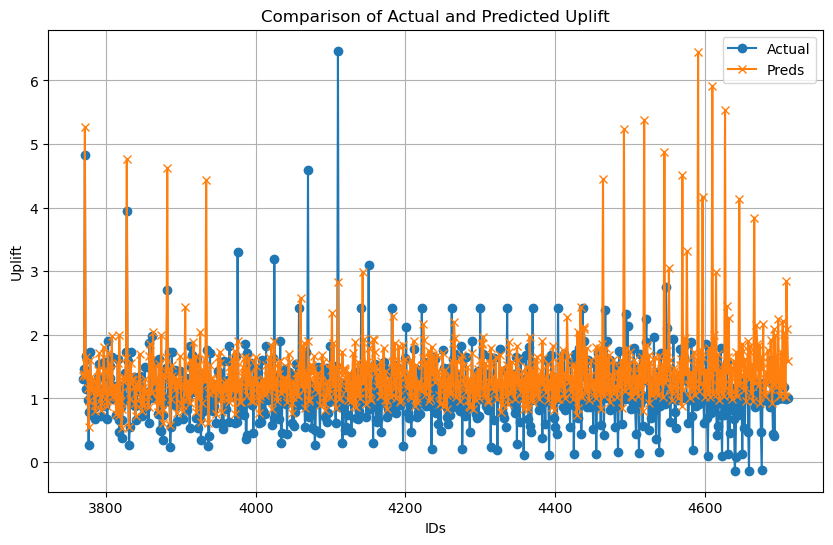

In [30]:
# Evaluate the model on a hold-out set if available
y_pred_holdout = best_model.predict(X_test)

# Compute the MSE for the holdout data
mse_holdout = mean_squared_error(Y_test, y_pred_holdout)
print(f'Mean Squared Error on test set: {mse_holdout}')

# Plot the Series

# Assign the Y_test index to the predictions 
y_pred_holdout = pd.Series(y_pred_holdout, index = Y_test.index)

plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='Actual', marker='o')
plt.plot(y_pred_holdout, label='Preds', marker='x')

# Customize the plot
plt.xlabel('IDs')
plt.ylabel('Uplift')
plt.title('Comparison of Actual and Predicted Uplift')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

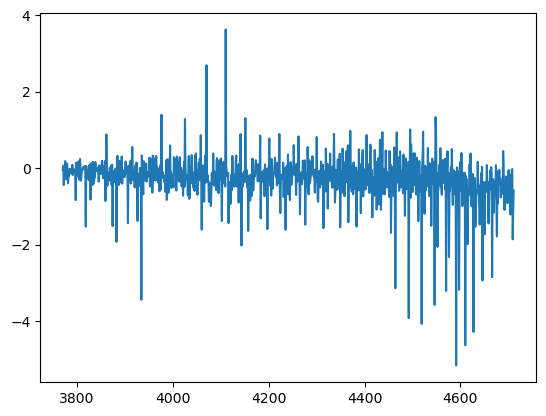

In [31]:
# Plot the residuals 
plt.plot(Y_test.index, Y_test - y_pred_holdout)
plt.show()

In [32]:
# Check the accuracy
compute_accuracy(Y_test, y_pred_holdout)

Prediction accuracy: 61.1%



In [33]:
# Get the models predictions for each of the fund strategies 
model = 'XGB_model.json'
all_preds = accuracy_pipeline(X_test, Y_test, saved_model=model)

# Get the predictions for each strategy, order is 1 : VC, 2: MediumBO, 3: MegaBO
predictions_by_strat = [compute_accuracy(x[0], x[1]) for x in all_preds]

Prediction accuracy: 73.5%

Prediction accuracy: 62.8%

Prediction accuracy: 47.2%



### Look at the feature importance 

In [34]:
# Get the most important features 
feature_importance = best_model.feature_importances_

feature_df = pd.DataFrame({'Feature': X_train.columns, 
                           'Importance': feature_importance})

feature_importance = feature_df.sort_values(by='Importance', ascending=False)
feature_importance.head(10)

,Feature,Importance
396,Commitment_USD_cumulative FMV_cumulative_growt...,0.108832
1380,Cost_growth_10 Fund_Vintage_MinMax_Expanding,0.068796
313,FMV_USD_cumulative RVPI,0.057376
1105,Distribution_growth_4 Cost_commitment_ratio_cu...,0.041656
149,Quarter_TzeroID Distribution_growth_12,0.033085
1275,Cost_growth_8 Fund_Vintage_MinMax_Expanding,0.030110
36,DPI_8,0.019158
360,Commitment_USD_cumulative RVPI,0.017316
279,Cost_USD_cumulative DPI_2,0.017086
1303,TVPI_8 RVPI_10,0.015784


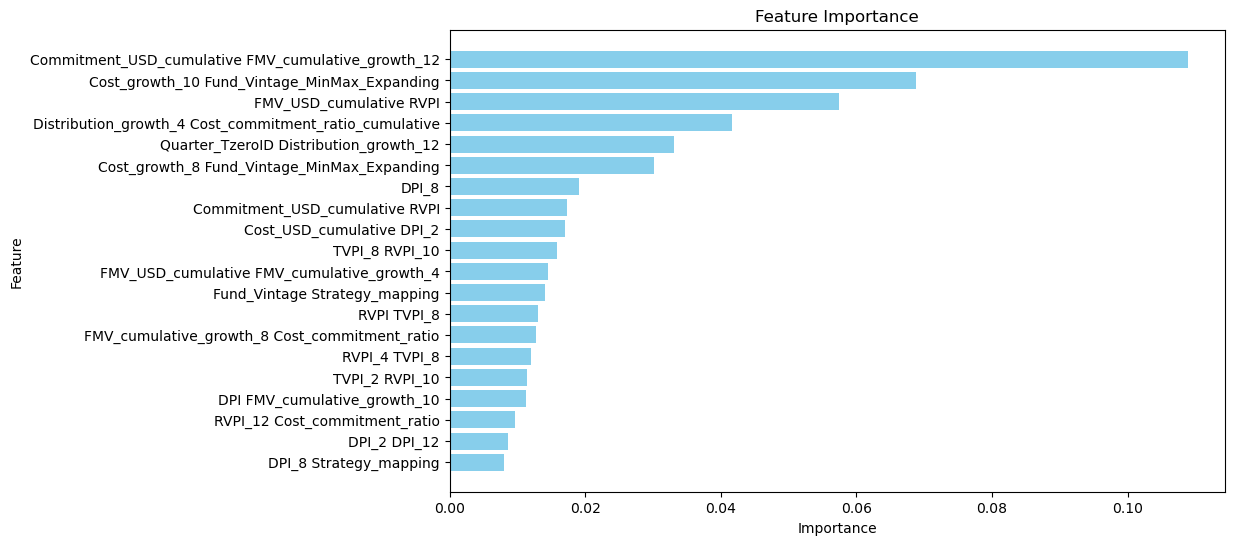

In [35]:
# Visualise the feature importance 
plt.figure(figsize=[10,6])
# Do for the top 20 features 
plt.barh(feature_importance['Feature'].iloc[:20], feature_importance['Importance'].iloc[:20], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top)